<a href="https://colab.research.google.com/github/KatBCN/ML-PropertyAssessment/blob/main/ML_Modeling_LinearRegression2_PropertyAssessment_Buffalo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

June 6: Using newly imputed training data from the imputed folder

In [35]:
# import libraries
from google.colab import drive 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# set options
pd.set_option('display.max_columns', None) 
sns.set()

# mount drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ML/ML-Project/data/
%ls 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ML/ML-Project/data
imputed/  initial_splits/  preprocessed/  source_data/


This notebook uses data from the preprocessed data folder.

In [36]:
# load train data
df = pd.read_pickle("/content/drive/MyDrive/ML/ML-Project/data/imputed/train_BuffaloProperty_ohe_imputer3.pkl")


- Imputed folder: The training data set has 35,921 rows and 22 columns.

In [37]:
df.shape

(35921, 22)

😔  The datatypes got messed up after imputation and conversions from one hot encoding.

In [38]:
df.dtypes

Front                         float64
Depth                         float64
Sale Price                    float64
Year Built                    float64
Total Living Area             float64
# of Fireplaces               float64
# of Beds                     float64
# of Baths                    float64
Latitude                      float64
Longitude                     float64
SameOwnerFirstName            float64
TotalBaths                    float64
Property Class Description     object
Previous Property Class        object
Overall Condition              object
Building Style                 object
Heat Type                      object
Basement Type                  object
Neighborhood                   object
OwnershipType                  object
Sale Type                      object
Total Value                   float64
dtype: object

In [39]:
df['OwnershipType'].value_counts()

Person         32436
Corporation     3388
Buffalo           97
Name: OwnershipType, dtype: int64

In [40]:
df["Property Class Description"].describe()

count                   35921
unique                      2
top       ONE FAMILY DWELLING
freq                    20969
Name: Property Class Description, dtype: object

In [41]:
df['Property Class Description'].value_counts()

ONE FAMILY DWELLING    20969
TWO FAMILY DWELLING    14952
Name: Property Class Description, dtype: int64

In the linear regression, we are only interested in numeric variables, so I will define which columns are numeric.

In [42]:
# select numeric columns
cols = df.select_dtypes(include=np.number).columns.tolist()
cols

['Front',
 'Depth',
 'Sale Price',
 'Year Built',
 'Total Living Area',
 '# of Fireplaces',
 '# of Beds',
 '# of Baths',
 'Latitude',
 'Longitude',
 'SameOwnerFirstName',
 'TotalBaths',
 'Total Value']

There are no missing values in this data, because it has been pre-processed with outlier detection and imputation.

In [43]:
print("Count of null values per numeric column:")
print(df[cols].isna().sum())

Count of null values per numeric column:
Front                 0
Depth                 0
Sale Price            0
Year Built            0
Total Living Area     0
# of Fireplaces       0
# of Beds             0
# of Baths            0
Latitude              0
Longitude             0
SameOwnerFirstName    0
TotalBaths            0
Total Value           0
dtype: int64


Sale Price may not be a very reliable variable to use. The imputation allowed a nonrealistic value to appear which is negative. The imputer should be checked to make sure 0 is the minimum imputation value.

We still have Front and Total Living Area minimum values of 1, which I thought would be outliers...

In [44]:
df.describe()

,Front,Depth,Sale Price,Year Built,Total Living Area,# of Fireplaces,# of Beds,# of Baths,Latitude,Longitude,SameOwnerFirstName,TotalBaths,Total Value
count,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.00000
mean,35.980845,118.434797,65681.880972,1919.137218,1816.398382,0.137691,4.054481,1.548184,42.910772,-78.841977,0.242087,1.692464,62981.46104
std,8.959981,23.061491,60566.228115,24.527781,615.595974,0.405385,1.303909,0.545249,0.034926,0.031105,0.428353,0.611045,52493.43274
min,1.000000,27.400000,-26321.884256,1800.000000,1.000000,0.000000,0.000000,0.000000,42.832090,-78.908661,0.000000,0.000000,1000.00000
25%,30.000000,105.000000,26000.000000,1900.000000,1325.000000,0.000000,3.000000,1.000000,42.890035,-78.864922,0.000000,1.000000,32000.00000
50%,33.000000,115.000000,49000.000000,1920.000000,1708.000000,0.000000,4.000000,2.000000,42.917171,-78.835212,0.000000,2.000000,48900.00000
75%,40.000000,130.000000,84000.000000,1927.000000,2244.000000,0.000000,5.000000,2.000000,42.940270,-78.815053,0.000000,2.000000,74000.00000
max,70.000000,209.000000,400000.000000,2018.000000,4954.000000,7.000000,12.000000,8.000000,42.964978,-78.799098,1.000000,8.000000,400000.00000


I will create a new column called "Age" which is the year 2020 - Year Built

In [45]:
df["Age"] = 2020 - df["Year Built"]

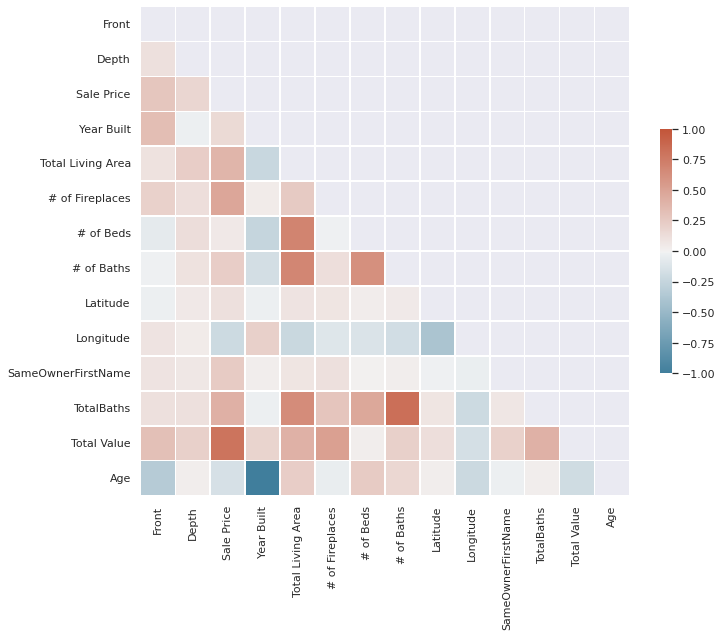

In [46]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin= -1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

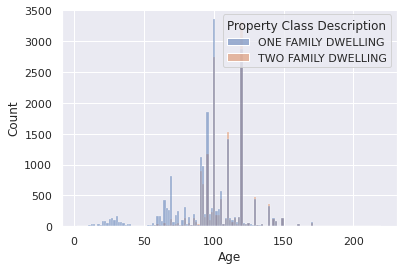

In [47]:
sns.histplot(data=df, x='Age', hue="Property Class Description")

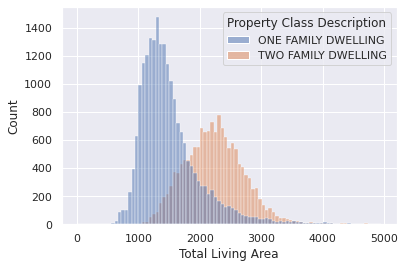

In [48]:
sns.histplot(data=df, x='Total Living Area', hue="Property Class Description")

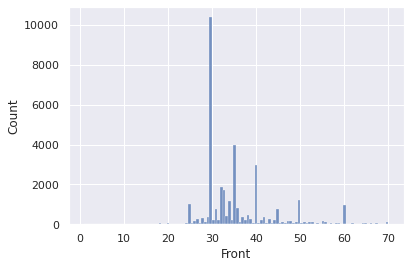

In [49]:
sns.histplot(data=df, x='Front')

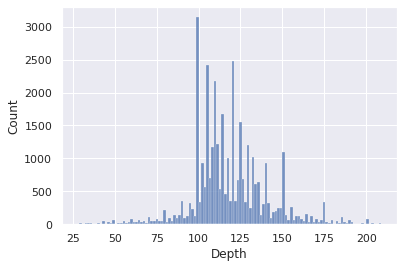

In [50]:
sns.histplot(data=df, x='Depth')

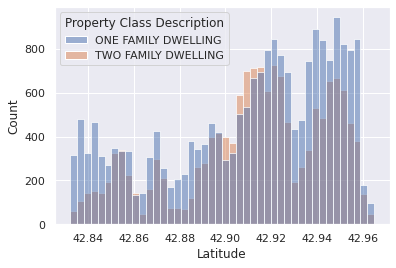

In [51]:
sns.histplot(data=df, x='Latitude', hue="Property Class Description")

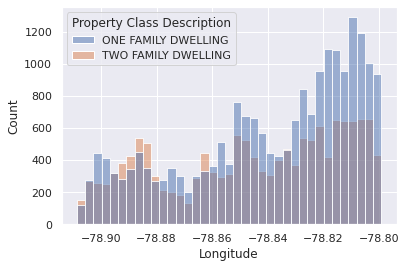

In [52]:
sns.histplot(data=df, x='Longitude', hue="Property Class Description")

Sale Price may not be the most reliable variable since it was imputed.

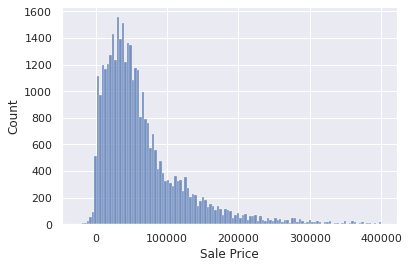

In [53]:
sns.histplot(data=df, x='Sale Price')

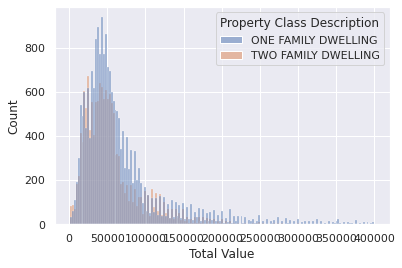

In [54]:
sns.histplot(data=df, x='Total Value', hue = "Property Class Description")

* [sklearn.preprocessing.PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
* [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)
* [How to Transform Target Variables for Regression in Python](https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/)

In [55]:
numeric_features = ["Front", "Age", "Total Living Area", "# of Fireplaces", "# of Beds", "TotalBaths"]

categorical_features = ["Property Class Description", "Neighborhood"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [56]:
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age", "Total Living Area", "# of Fireplaces", "# of Beds", "TotalBaths"]

In [57]:
train_x = df[regression_cols]

In [58]:
train_y = df["Total Value"]

In [59]:
# prepare the model with input scaling
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ('model', LinearRegression())])
# fit pipeline
pipeline.fit(train_x, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Property Class Description',
                                                   'Neighborhood'])])),
                ('model', LinearRegression())])

In [60]:
yhat_train = pipeline.predict(train_x)

In [61]:
# The mean squared error for training data
print("Mean squared error: %.2f" % mean_squared_error(train_y, yhat_train))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(train_y, yhat_train))

Mean squared error: 1178757907.56
Coefficient of determination: 0.57


In [64]:
pipeline.named_steps['model'].coef_

array([  4389.62943633,  -4389.62943669,  36526.26511735, -36734.6525652 ,
       -48887.74850457, 158861.48015928,  67955.48819432, -41540.26534668,
       -36199.69886761,  68862.42251716,  70315.9115367 , -43231.5204851 ,
       -46011.93755742, -45665.14532701, -48516.58261446, -31950.7512901 ,
       -23005.1076902 , -21522.88130971, -12799.32037553, -26078.39737335,
       -24446.41794559, -26314.45405664, -14730.87546501, -48572.17249446,
       -43213.260328  ,  37143.18484779,  86236.51084477,  -8758.24438165,
       -23159.45974631, -30742.20134015, -41686.06520419, -13686.37872444,
         5942.27714609, 283852.36202342,  -5294.54473815, -36832.46075981,
       -15341.43189885, -20773.92599656])